# Binary Classification Using Handcrafted Features and ML Classifiers

In [16]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Paths to your datasets
MASK_PATH = 'mask_dataset/with_mask'
NO_MASK_PATH = 'mask_dataset/without_mask'

In [17]:
# Feature extraction using HOG and LBP
def extract_hl_features(image):

    # HOG features
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                       block_norm='L2-Hys', transform_sqrt=True, feature_vector=True)
    
    return hog_features 

In [18]:
def extract_sift_features(image):

    # SIFT features
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is not None:
        # Flatten descriptors to fixed size using mean
        features = descriptors.mean(axis=0)
    else:
        # Return zeros if no descriptors are found (128-dimensional for SIFT)
        features = np.zeros(128)
    
    return features

In [19]:
# Load dataset
def load_dataset(path, label):
    features = []
    labels = []
    unique_images = []
    for file in os.listdir(path):
        if file.endswith(('jpg', 'png', 'jpeg')):
            img = cv2.imread(os.path.join(path, file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128, 128))
            if not any(np.array_equal(img, unique) for unique in unique_images): # Duplicates
                unique_images.append(img)
                features.append(extract_hl_features(img))
                labels.append(label)
    return features, labels

# Load data
mask_features, mask_labels = load_dataset(MASK_PATH, 1)
no_mask_features, no_mask_labels = load_dataset(NO_MASK_PATH, 0)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [20]:
# Combine and split data
X = np.array(mask_features + no_mask_features)
y = np.array(mask_labels + no_mask_labels)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# Train SVM classifier
svm_clf = SVC(kernel='rbf', C=2, gamma="scale")
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

In [23]:
# Evaluate models
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print("SVM F1-Score:", f1_score(y_test,svm_pred))

SVM Accuracy: 0.9335006273525721
SVM F1-Score: 0.9407821229050279


In [24]:
log_reg_clf = LogisticRegression(max_iter=500, solver="liblinear", C=0.5, random_state=42)
# Train the classifier
log_reg_clf.fit(X_train, y_train)
# Make predictions on the test set
log_reg_pred = log_reg_clf.predict(X_test)

In [25]:
# Calculate accuracy
print(f"Logistic Regression accuracy:", accuracy_score(y_test, log_reg_pred))
print("Logistic Regression F1-Score:", f1_score(y_test,log_reg_pred))

Logistic Regression accuracy: 0.8920953575909661
Logistic Regression F1-Score: 0.9024943310657596


In [26]:
# Train Neural Network classifier
nn_clf = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, activation='relu', solver='adam', random_state=42)
nn_clf.fit(X_train, y_train)
nn_pred = nn_clf.predict(X_test)

In [27]:
print("NN Accuracy:", accuracy_score(y_test, nn_pred))
print("NN F1-Score:", f1_score(y_test,nn_pred))

NN Accuracy: 0.93099121706399
NN F1-Score: 0.9379932356257046


# Binary Classification Using CNN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import shutil

## Binary Classification using CNN in PyTorch
This part of the Jupyter Notebook trains a CNN model to classify images as "with_mask" or "without_mask" using the PyTorch framework. We will:

1. Load and preprocess the dataset.
2. Define a CNN architecture.
3. Train the model using different hyperparameters.
4. Evaluate the performance with accuracy graphs.

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 1: Dataset Preparation
We first load the dataset and split it into training (80%) and testing (20%) sets, ensuring no overlap.

In [5]:
# Define dataset path
data_dir = "mask_dataset"
train_dir = "train_dataset"
test_dir = "test_dataset"

In [6]:
# Ensure train and test directories are clean
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [7]:
# Split dataset into 80% training and 20% testing without overlap
classes = ["with_mask", "without_mask"]
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

## Step 2: Data Augmentation and Loading
We apply transformations to augment the dataset and prepare it for training.

In [9]:
# Image parameters
img_height, img_width = 150, 150
batch_size = 32

In [10]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [11]:
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Step 3: Define CNN Model
We create a CNN model with configurable activation functions.

In [14]:
class CNN(nn.Module):
    def __init__(self, activation_fn):
        super(CNN, self).__init__()
        self.activation = activation_fn
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

## Step 4: Training Function
We define a function to train the model and track accuracy over epochs.

In [16]:
def train_model(model, criterion, optimizer, epochs=15):
    model.to(device)
    train_acc = []
    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        accuracy = correct / total
        train_acc.append(accuracy)
        print(f"Epoch {epoch+1}, Accuracy: {accuracy:.4f}")
    return train_acc

## Step 5: Hyperparameter Tuning
We experiment with different learning rates, batch sizes, optimizers, and activation functions.

In [18]:
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
optimizers = ['adam', 'sgd', 'rmsprop']
activations = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}

Training with lr=0.01, batch_size=32, optimizer=adam, activation=relu


C:\Users\Tahir\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Accuracy: 0.5267
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5285
Epoch 4, Accuracy: 0.5285
Epoch 5, Accuracy: 0.5285
Epoch 6, Accuracy: 0.5285
Epoch 7, Accuracy: 0.5285
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5285
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5285
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5285


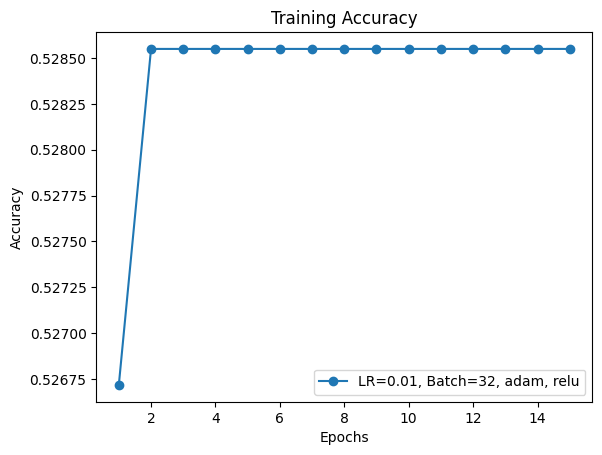

Training with lr=0.01, batch_size=32, optimizer=adam, activation=sigmoid
Epoch 1, Accuracy: 0.5075
Epoch 2, Accuracy: 0.5267
Epoch 3, Accuracy: 0.5060
Epoch 4, Accuracy: 0.5102
Epoch 5, Accuracy: 0.5011
Epoch 6, Accuracy: 0.5108
Epoch 7, Accuracy: 0.4965
Epoch 8, Accuracy: 0.5032
Epoch 9, Accuracy: 0.5053
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5047
Epoch 12, Accuracy: 0.5163
Epoch 13, Accuracy: 0.5072
Epoch 14, Accuracy: 0.4968
Epoch 15, Accuracy: 0.4986


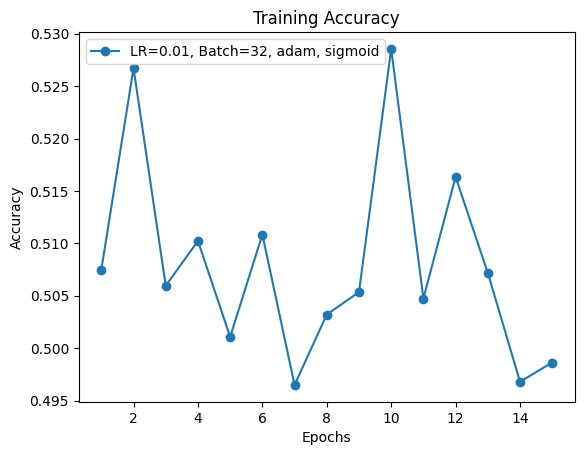

Training with lr=0.01, batch_size=32, optimizer=adam, activation=tanh
Epoch 1, Accuracy: 0.5475
Epoch 2, Accuracy: 0.6702
Epoch 3, Accuracy: 0.7111
Epoch 4, Accuracy: 0.6867
Epoch 5, Accuracy: 0.6968
Epoch 6, Accuracy: 0.7227
Epoch 7, Accuracy: 0.6305
Epoch 8, Accuracy: 0.6373
Epoch 9, Accuracy: 0.6574
Epoch 10, Accuracy: 0.6916
Epoch 11, Accuracy: 0.7072
Epoch 12, Accuracy: 0.7487
Epoch 13, Accuracy: 0.7576
Epoch 14, Accuracy: 0.7118
Epoch 15, Accuracy: 0.7197


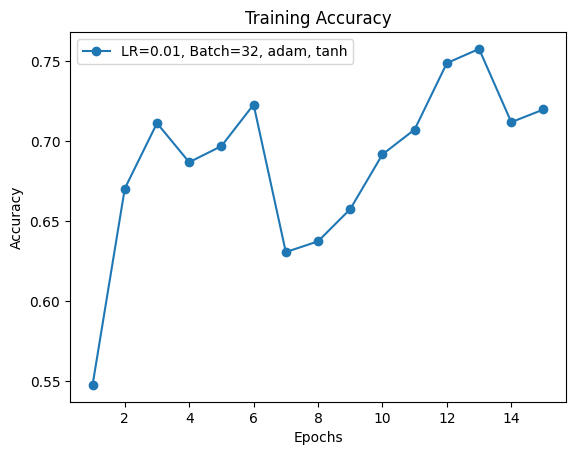

Training with lr=0.01, batch_size=32, optimizer=sgd, activation=relu
Epoch 1, Accuracy: 0.7658
Epoch 2, Accuracy: 0.8861
Epoch 3, Accuracy: 0.9044
Epoch 4, Accuracy: 0.9224
Epoch 5, Accuracy: 0.9166
Epoch 6, Accuracy: 0.9402
Epoch 7, Accuracy: 0.9438
Epoch 8, Accuracy: 0.9438
Epoch 9, Accuracy: 0.9502
Epoch 10, Accuracy: 0.9573
Epoch 11, Accuracy: 0.9588
Epoch 12, Accuracy: 0.9585
Epoch 13, Accuracy: 0.9655
Epoch 14, Accuracy: 0.9661
Epoch 15, Accuracy: 0.9692


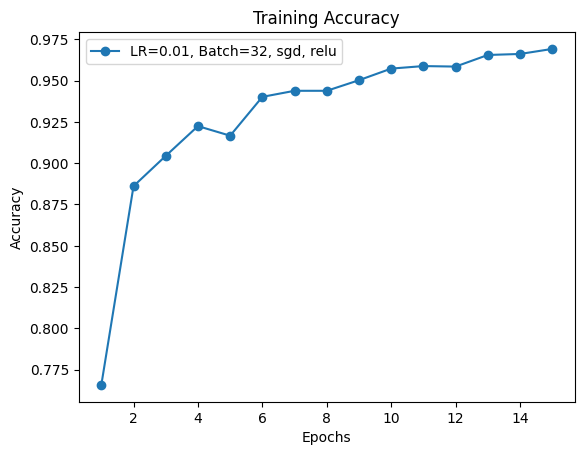

Training with lr=0.01, batch_size=32, optimizer=sgd, activation=sigmoid
Epoch 1, Accuracy: 0.5108
Epoch 2, Accuracy: 0.5215
Epoch 3, Accuracy: 0.5151
Epoch 4, Accuracy: 0.5218
Epoch 5, Accuracy: 0.5224
Epoch 6, Accuracy: 0.5072
Epoch 7, Accuracy: 0.5176
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5145
Epoch 10, Accuracy: 0.5133
Epoch 11, Accuracy: 0.5285
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5176
Epoch 14, Accuracy: 0.5084
Epoch 15, Accuracy: 0.5285


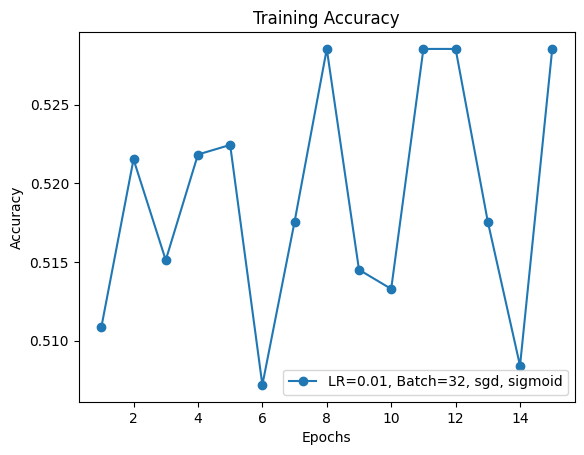

Training with lr=0.01, batch_size=32, optimizer=sgd, activation=tanh
Epoch 1, Accuracy: 0.8434
Epoch 2, Accuracy: 0.8977
Epoch 3, Accuracy: 0.9108
Epoch 4, Accuracy: 0.9154
Epoch 5, Accuracy: 0.9191
Epoch 6, Accuracy: 0.9374
Epoch 7, Accuracy: 0.9502
Epoch 8, Accuracy: 0.9527
Epoch 9, Accuracy: 0.9569
Epoch 10, Accuracy: 0.9606
Epoch 11, Accuracy: 0.9673
Epoch 12, Accuracy: 0.9725
Epoch 13, Accuracy: 0.9701
Epoch 14, Accuracy: 0.9707
Epoch 15, Accuracy: 0.9734


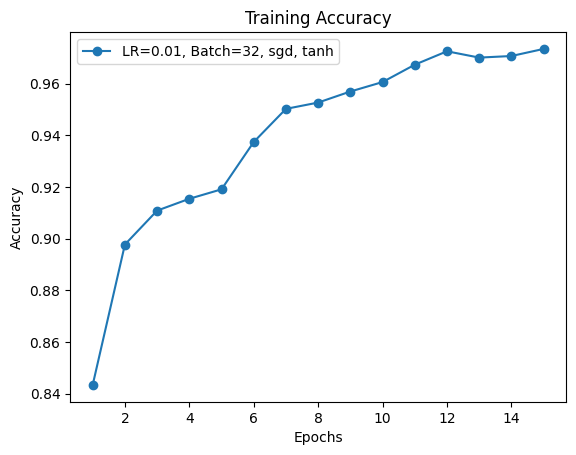

Training with lr=0.01, batch_size=32, optimizer=rmsprop, activation=relu
Epoch 1, Accuracy: 0.5270
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5285
Epoch 4, Accuracy: 0.5285
Epoch 5, Accuracy: 0.5285
Epoch 6, Accuracy: 0.5285
Epoch 7, Accuracy: 0.5285
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5285
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5285
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5285


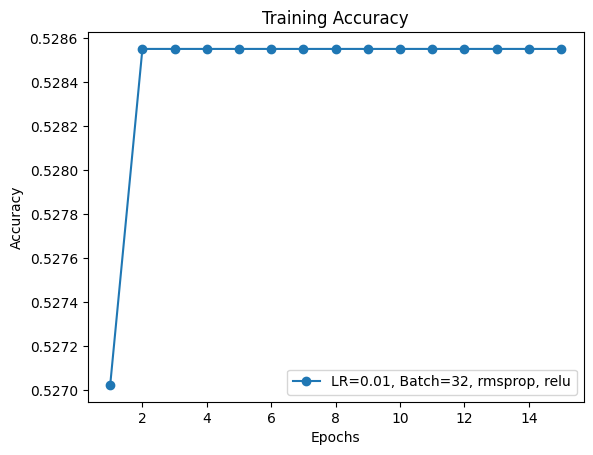

Training with lr=0.01, batch_size=32, optimizer=rmsprop, activation=sigmoid
Epoch 1, Accuracy: 0.5023
Epoch 2, Accuracy: 0.5105
Epoch 3, Accuracy: 0.5035
Epoch 4, Accuracy: 0.4907
Epoch 5, Accuracy: 0.5182
Epoch 6, Accuracy: 0.5075
Epoch 7, Accuracy: 0.5111
Epoch 8, Accuracy: 0.5075
Epoch 9, Accuracy: 0.4980
Epoch 10, Accuracy: 0.5044
Epoch 11, Accuracy: 0.5047
Epoch 12, Accuracy: 0.5163
Epoch 13, Accuracy: 0.4916
Epoch 14, Accuracy: 0.4971
Epoch 15, Accuracy: 0.5139


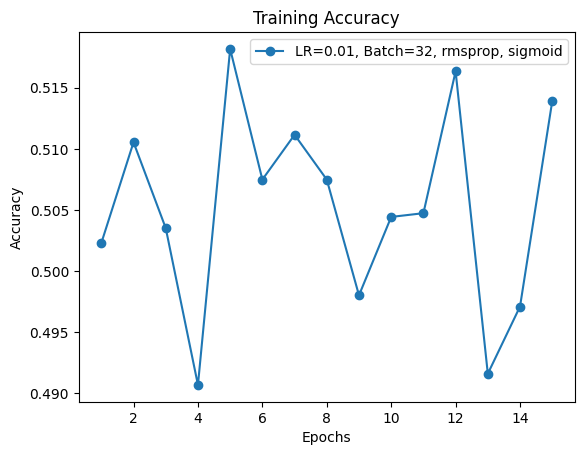

Training with lr=0.01, batch_size=32, optimizer=rmsprop, activation=tanh
Epoch 1, Accuracy: 0.5615
Epoch 2, Accuracy: 0.6147
Epoch 3, Accuracy: 0.6776
Epoch 4, Accuracy: 0.7185
Epoch 5, Accuracy: 0.7939
Epoch 6, Accuracy: 0.7490
Epoch 7, Accuracy: 0.7322
Epoch 8, Accuracy: 0.7337
Epoch 9, Accuracy: 0.7518
Epoch 10, Accuracy: 0.7597
Epoch 11, Accuracy: 0.7472
Epoch 12, Accuracy: 0.7759
Epoch 13, Accuracy: 0.7884
Epoch 14, Accuracy: 0.8198
Epoch 15, Accuracy: 0.7521


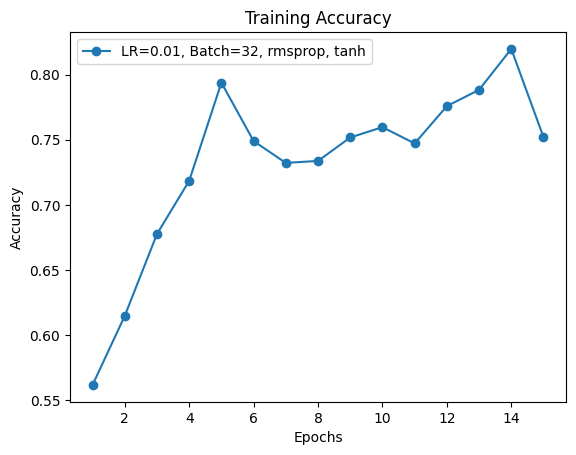

Training with lr=0.01, batch_size=64, optimizer=adam, activation=relu
Epoch 1, Accuracy: 0.5279
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5285
Epoch 4, Accuracy: 0.5285
Epoch 5, Accuracy: 0.5285
Epoch 6, Accuracy: 0.5285
Epoch 7, Accuracy: 0.5285
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5285
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5285
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5285


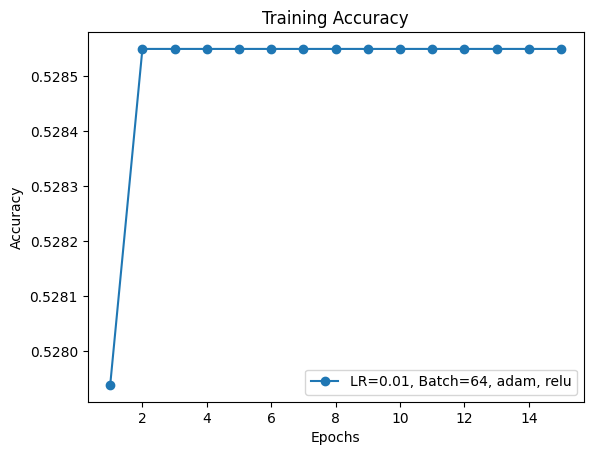

Training with lr=0.01, batch_size=64, optimizer=adam, activation=sigmoid
Epoch 1, Accuracy: 0.5154
Epoch 2, Accuracy: 0.5194
Epoch 3, Accuracy: 0.5041
Epoch 4, Accuracy: 0.5148
Epoch 5, Accuracy: 0.4913
Epoch 6, Accuracy: 0.4904
Epoch 7, Accuracy: 0.5102
Epoch 8, Accuracy: 0.5078
Epoch 9, Accuracy: 0.5035
Epoch 10, Accuracy: 0.5044
Epoch 11, Accuracy: 0.5029
Epoch 12, Accuracy: 0.5151
Epoch 13, Accuracy: 0.5029
Epoch 14, Accuracy: 0.5008
Epoch 15, Accuracy: 0.5072


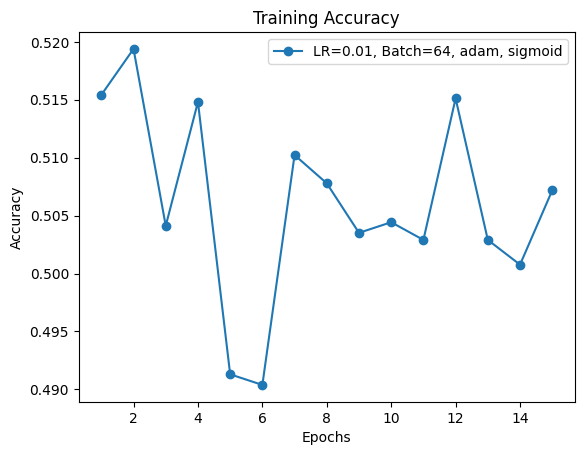

Training with lr=0.01, batch_size=64, optimizer=adam, activation=tanh
Epoch 1, Accuracy: 0.6208
Epoch 2, Accuracy: 0.7417
Epoch 3, Accuracy: 0.7255
Epoch 4, Accuracy: 0.6922
Epoch 5, Accuracy: 0.7203
Epoch 6, Accuracy: 0.6678
Epoch 7, Accuracy: 0.7121
Epoch 8, Accuracy: 0.7316
Epoch 9, Accuracy: 0.7759
Epoch 10, Accuracy: 0.7579
Epoch 11, Accuracy: 0.7508
Epoch 12, Accuracy: 0.7426
Epoch 13, Accuracy: 0.7484
Epoch 14, Accuracy: 0.7478
Epoch 15, Accuracy: 0.7316


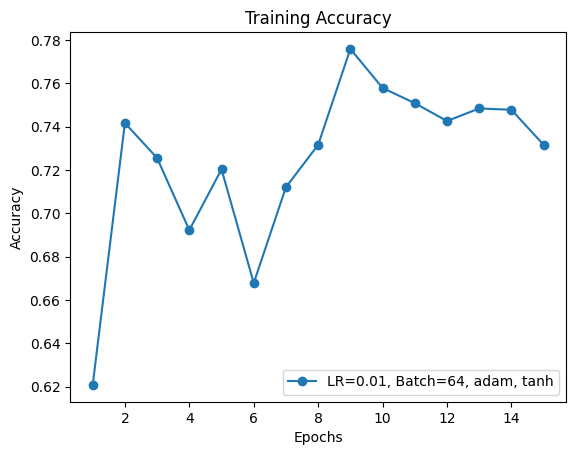

Training with lr=0.01, batch_size=64, optimizer=sgd, activation=relu
Epoch 1, Accuracy: 0.7643
Epoch 2, Accuracy: 0.8904
Epoch 3, Accuracy: 0.8983
Epoch 4, Accuracy: 0.9209
Epoch 5, Accuracy: 0.9313
Epoch 6, Accuracy: 0.9356
Epoch 7, Accuracy: 0.9411
Epoch 8, Accuracy: 0.9518
Epoch 9, Accuracy: 0.9545
Epoch 10, Accuracy: 0.9618
Epoch 11, Accuracy: 0.9643
Epoch 12, Accuracy: 0.9667
Epoch 13, Accuracy: 0.9573
Epoch 14, Accuracy: 0.9725
Epoch 15, Accuracy: 0.9716


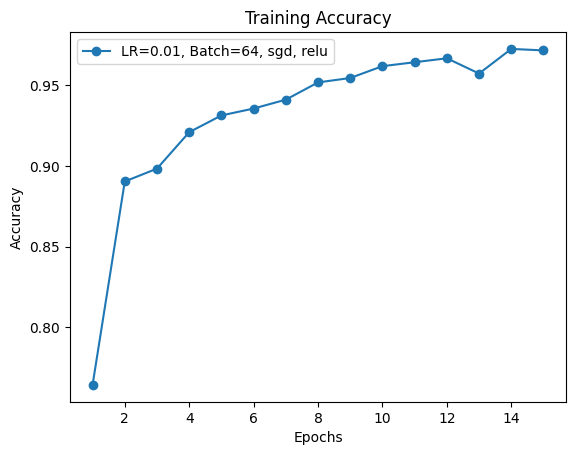

Training with lr=0.01, batch_size=64, optimizer=sgd, activation=sigmoid
Epoch 1, Accuracy: 0.5096
Epoch 2, Accuracy: 0.5231
Epoch 3, Accuracy: 0.5029
Epoch 4, Accuracy: 0.5270
Epoch 5, Accuracy: 0.5029
Epoch 6, Accuracy: 0.5182
Epoch 7, Accuracy: 0.5081
Epoch 8, Accuracy: 0.5267
Epoch 9, Accuracy: 0.5072
Epoch 10, Accuracy: 0.5212
Epoch 11, Accuracy: 0.5246
Epoch 12, Accuracy: 0.5160
Epoch 13, Accuracy: 0.5267
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5188


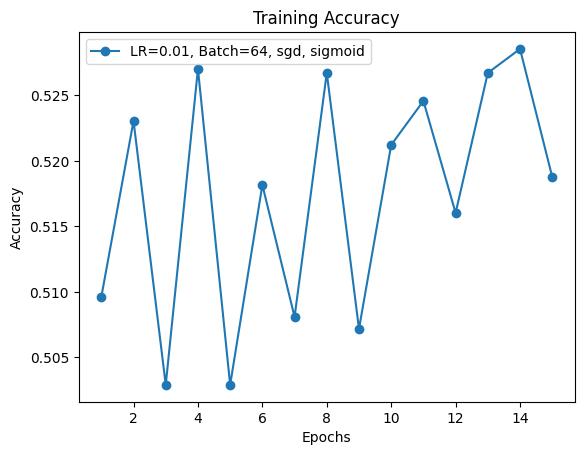

Training with lr=0.01, batch_size=64, optimizer=sgd, activation=tanh
Epoch 1, Accuracy: 0.8568
Epoch 2, Accuracy: 0.9011
Epoch 3, Accuracy: 0.8986
Epoch 4, Accuracy: 0.9090
Epoch 5, Accuracy: 0.9276
Epoch 6, Accuracy: 0.9331
Epoch 7, Accuracy: 0.9472
Epoch 8, Accuracy: 0.9444
Epoch 9, Accuracy: 0.9582
Epoch 10, Accuracy: 0.9597
Epoch 11, Accuracy: 0.9664
Epoch 12, Accuracy: 0.9637
Epoch 13, Accuracy: 0.9612
Epoch 14, Accuracy: 0.9719
Epoch 15, Accuracy: 0.9719


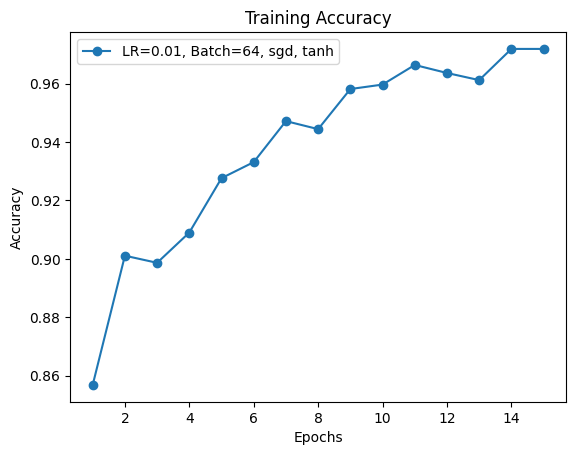

Training with lr=0.01, batch_size=64, optimizer=rmsprop, activation=relu
Epoch 1, Accuracy: 0.5282
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5285
Epoch 4, Accuracy: 0.5285
Epoch 5, Accuracy: 0.5285
Epoch 6, Accuracy: 0.5285
Epoch 7, Accuracy: 0.5285
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5285
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5285
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5285


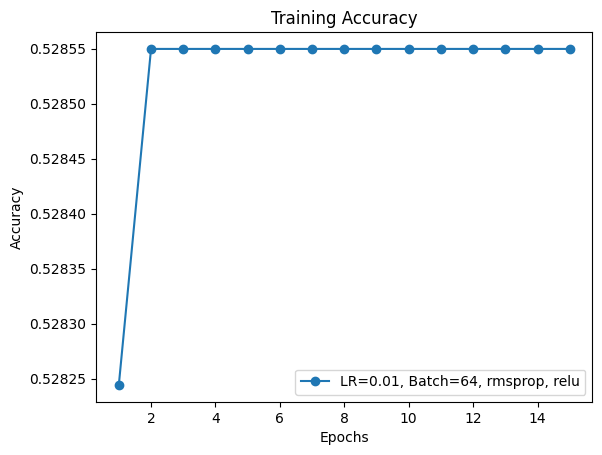

Training with lr=0.01, batch_size=64, optimizer=rmsprop, activation=sigmoid
Epoch 1, Accuracy: 0.5111
Epoch 2, Accuracy: 0.4889
Epoch 3, Accuracy: 0.5041
Epoch 4, Accuracy: 0.5176
Epoch 5, Accuracy: 0.5066
Epoch 6, Accuracy: 0.5084
Epoch 7, Accuracy: 0.5166
Epoch 8, Accuracy: 0.5096
Epoch 9, Accuracy: 0.5063
Epoch 10, Accuracy: 0.5047
Epoch 11, Accuracy: 0.5151
Epoch 12, Accuracy: 0.4962
Epoch 13, Accuracy: 0.5102
Epoch 14, Accuracy: 0.5053
Epoch 15, Accuracy: 0.5102


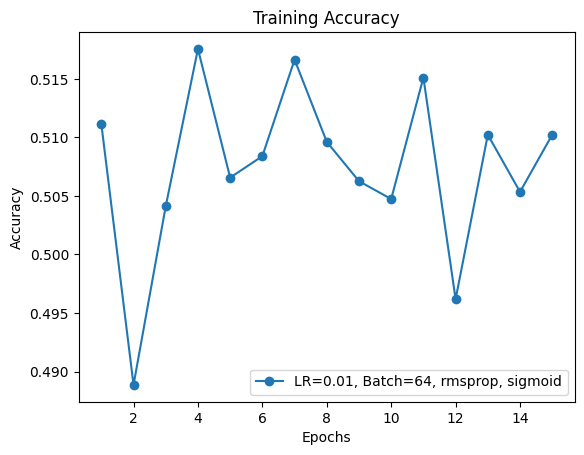

Training with lr=0.01, batch_size=64, optimizer=rmsprop, activation=tanh
Epoch 1, Accuracy: 0.6571
Epoch 2, Accuracy: 0.7289
Epoch 3, Accuracy: 0.7719
Epoch 4, Accuracy: 0.7298
Epoch 5, Accuracy: 0.7847
Epoch 6, Accuracy: 0.7398
Epoch 7, Accuracy: 0.7930
Epoch 8, Accuracy: 0.8037
Epoch 9, Accuracy: 0.8366
Epoch 10, Accuracy: 0.8174
Epoch 11, Accuracy: 0.7951
Epoch 12, Accuracy: 0.8235
Epoch 13, Accuracy: 0.8467
Epoch 14, Accuracy: 0.7249
Epoch 15, Accuracy: 0.7215


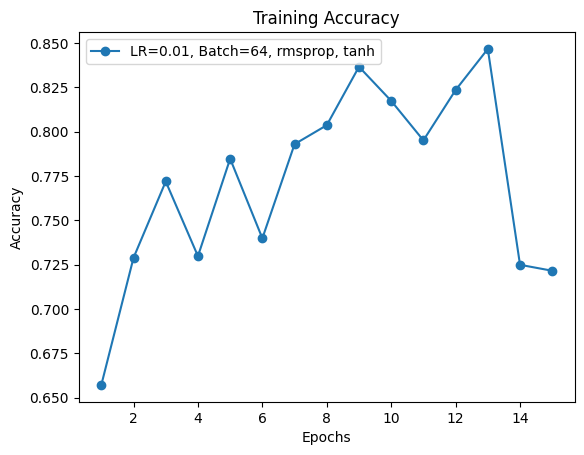

Training with lr=0.001, batch_size=32, optimizer=adam, activation=relu
Epoch 1, Accuracy: 0.8122
Epoch 2, Accuracy: 0.9197
Epoch 3, Accuracy: 0.9310
Epoch 4, Accuracy: 0.9313
Epoch 5, Accuracy: 0.9469
Epoch 6, Accuracy: 0.9508
Epoch 7, Accuracy: 0.9515
Epoch 8, Accuracy: 0.9573
Epoch 9, Accuracy: 0.9615
Epoch 10, Accuracy: 0.9576
Epoch 11, Accuracy: 0.9716
Epoch 12, Accuracy: 0.9652
Epoch 13, Accuracy: 0.9698
Epoch 14, Accuracy: 0.9731
Epoch 15, Accuracy: 0.9744


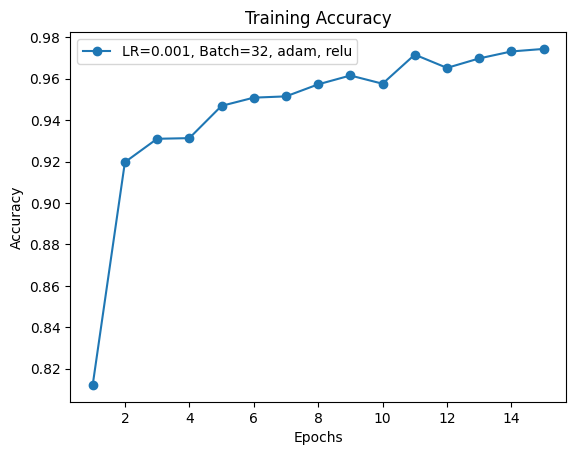

Training with lr=0.001, batch_size=32, optimizer=adam, activation=sigmoid
Epoch 1, Accuracy: 0.5285
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5182
Epoch 4, Accuracy: 0.5234
Epoch 5, Accuracy: 0.5285
Epoch 6, Accuracy: 0.5285
Epoch 7, Accuracy: 0.5151
Epoch 8, Accuracy: 0.5188
Epoch 9, Accuracy: 0.5285
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5212
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5157
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5157


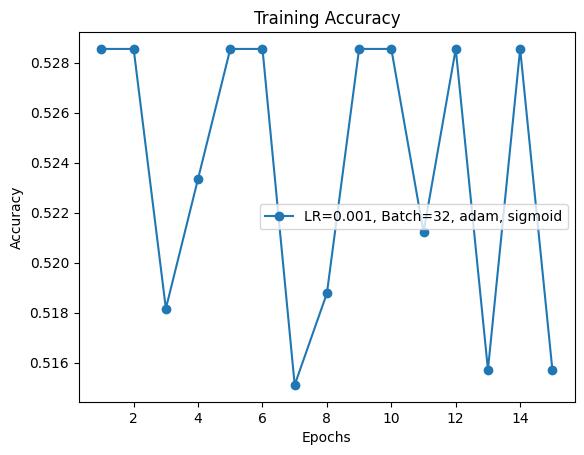

Training with lr=0.001, batch_size=32, optimizer=adam, activation=tanh
Epoch 1, Accuracy: 0.8333
Epoch 2, Accuracy: 0.8937
Epoch 3, Accuracy: 0.8944
Epoch 4, Accuracy: 0.8916
Epoch 5, Accuracy: 0.9017
Epoch 6, Accuracy: 0.8950
Epoch 7, Accuracy: 0.8882
Epoch 8, Accuracy: 0.8937
Epoch 9, Accuracy: 0.8736
Epoch 10, Accuracy: 0.8840
Epoch 11, Accuracy: 0.8913
Epoch 12, Accuracy: 0.8901
Epoch 13, Accuracy: 0.8947
Epoch 14, Accuracy: 0.8962
Epoch 15, Accuracy: 0.8730


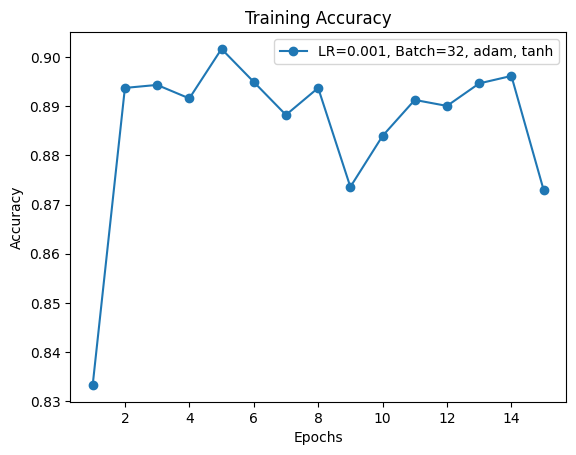

Training with lr=0.001, batch_size=32, optimizer=sgd, activation=relu
Epoch 1, Accuracy: 0.5289
Epoch 2, Accuracy: 0.7243
Epoch 3, Accuracy: 0.8672
Epoch 4, Accuracy: 0.8852
Epoch 5, Accuracy: 0.8916
Epoch 6, Accuracy: 0.8953
Epoch 7, Accuracy: 0.8940
Epoch 8, Accuracy: 0.8983
Epoch 9, Accuracy: 0.9014
Epoch 10, Accuracy: 0.9056
Epoch 11, Accuracy: 0.9105
Epoch 12, Accuracy: 0.9118
Epoch 13, Accuracy: 0.9142
Epoch 14, Accuracy: 0.9221
Epoch 15, Accuracy: 0.9258


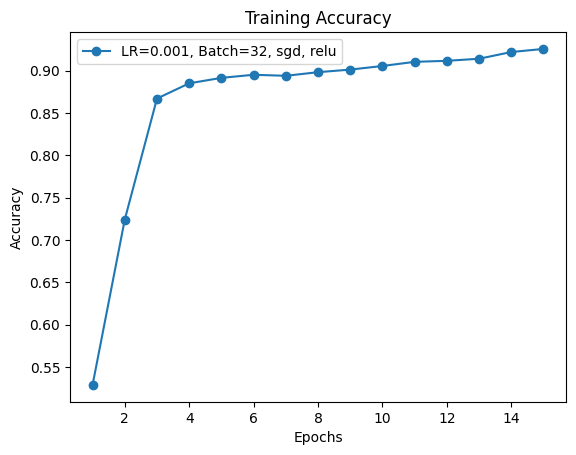

Training with lr=0.001, batch_size=32, optimizer=sgd, activation=sigmoid
Epoch 1, Accuracy: 0.5072
Epoch 2, Accuracy: 0.5063
Epoch 3, Accuracy: 0.5151
Epoch 4, Accuracy: 0.5087
Epoch 5, Accuracy: 0.5255
Epoch 6, Accuracy: 0.5127
Epoch 7, Accuracy: 0.5108
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5200
Epoch 10, Accuracy: 0.5264
Epoch 11, Accuracy: 0.5157
Epoch 12, Accuracy: 0.5157
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5224
Epoch 15, Accuracy: 0.5090


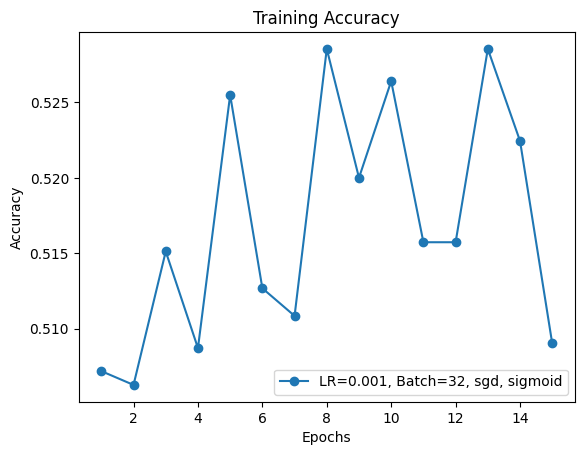

Training with lr=0.001, batch_size=32, optimizer=sgd, activation=tanh
Epoch 1, Accuracy: 0.7777
Epoch 2, Accuracy: 0.8791
Epoch 3, Accuracy: 0.8913
Epoch 4, Accuracy: 0.8962
Epoch 5, Accuracy: 0.9008
Epoch 6, Accuracy: 0.8995
Epoch 7, Accuracy: 0.9014
Epoch 8, Accuracy: 0.9029
Epoch 9, Accuracy: 0.9056
Epoch 10, Accuracy: 0.9102
Epoch 11, Accuracy: 0.9108
Epoch 12, Accuracy: 0.9160
Epoch 13, Accuracy: 0.9191
Epoch 14, Accuracy: 0.9203
Epoch 15, Accuracy: 0.9264


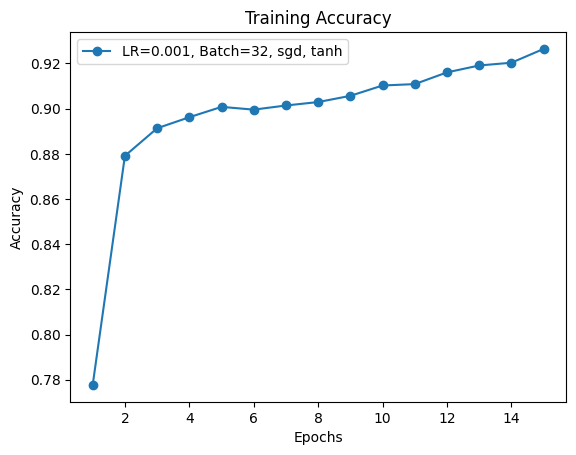

Training with lr=0.001, batch_size=32, optimizer=rmsprop, activation=relu
Epoch 1, Accuracy: 0.5285
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5285
Epoch 4, Accuracy: 0.5285
Epoch 5, Accuracy: 0.5285
Epoch 6, Accuracy: 0.5285
Epoch 7, Accuracy: 0.5285
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5285
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5285
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5285


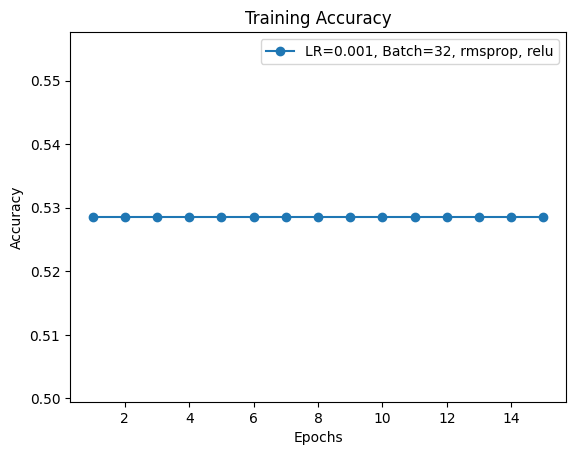

Training with lr=0.001, batch_size=32, optimizer=rmsprop, activation=sigmoid
Epoch 1, Accuracy: 0.5121
Epoch 2, Accuracy: 0.5224
Epoch 3, Accuracy: 0.5176
Epoch 4, Accuracy: 0.5231
Epoch 5, Accuracy: 0.5188
Epoch 6, Accuracy: 0.5243
Epoch 7, Accuracy: 0.5133
Epoch 8, Accuracy: 0.5231
Epoch 9, Accuracy: 0.5292
Epoch 10, Accuracy: 0.5169
Epoch 11, Accuracy: 0.5194
Epoch 12, Accuracy: 0.5212
Epoch 13, Accuracy: 0.5212
Epoch 14, Accuracy: 0.5218
Epoch 15, Accuracy: 0.5203


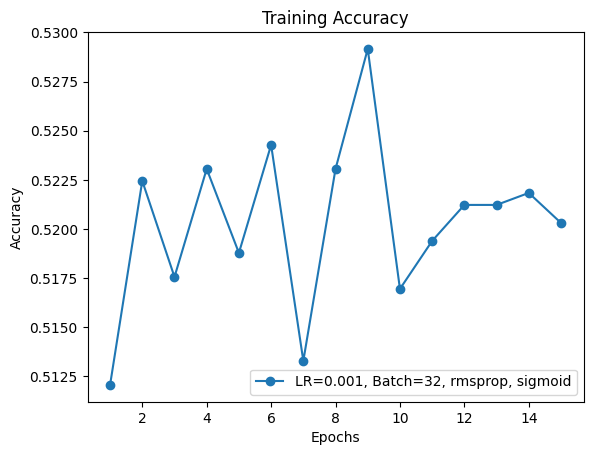

Training with lr=0.001, batch_size=32, optimizer=rmsprop, activation=tanh
Epoch 1, Accuracy: 0.5744
Epoch 2, Accuracy: 0.7740
Epoch 3, Accuracy: 0.8684
Epoch 4, Accuracy: 0.8763
Epoch 5, Accuracy: 0.8794
Epoch 6, Accuracy: 0.8800
Epoch 7, Accuracy: 0.8763
Epoch 8, Accuracy: 0.8803
Epoch 9, Accuracy: 0.8895
Epoch 10, Accuracy: 0.8779
Epoch 11, Accuracy: 0.8855
Epoch 12, Accuracy: 0.8907
Epoch 13, Accuracy: 0.8885
Epoch 14, Accuracy: 0.8913
Epoch 15, Accuracy: 0.8968


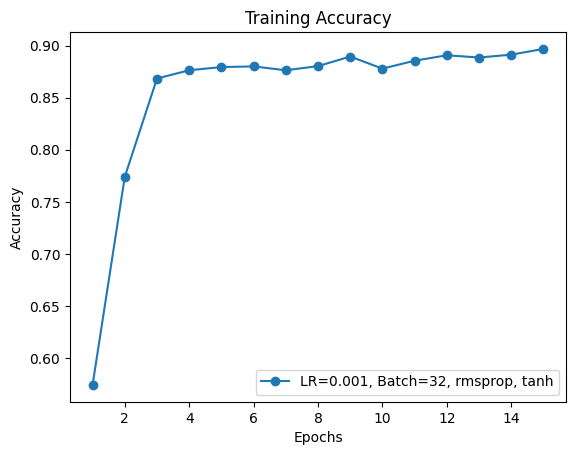

Training with lr=0.001, batch_size=64, optimizer=adam, activation=relu
Epoch 1, Accuracy: 0.8510
Epoch 2, Accuracy: 0.9218
Epoch 3, Accuracy: 0.9344
Epoch 4, Accuracy: 0.9469
Epoch 5, Accuracy: 0.9478
Epoch 6, Accuracy: 0.9487
Epoch 7, Accuracy: 0.9560
Epoch 8, Accuracy: 0.9634
Epoch 9, Accuracy: 0.9591
Epoch 10, Accuracy: 0.9750
Epoch 11, Accuracy: 0.9765
Epoch 12, Accuracy: 0.9756
Epoch 13, Accuracy: 0.9817
Epoch 14, Accuracy: 0.9835
Epoch 15, Accuracy: 0.9817


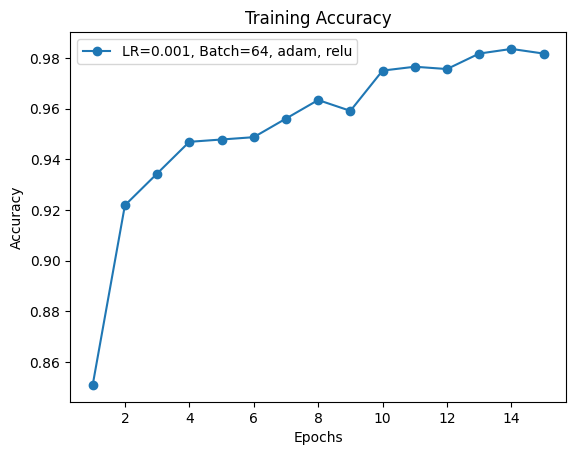

Training with lr=0.001, batch_size=64, optimizer=adam, activation=sigmoid
Epoch 1, Accuracy: 0.4986
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5212
Epoch 4, Accuracy: 0.5285
Epoch 5, Accuracy: 0.5188
Epoch 6, Accuracy: 0.5237
Epoch 7, Accuracy: 0.5285
Epoch 8, Accuracy: 0.5240
Epoch 9, Accuracy: 0.5194
Epoch 10, Accuracy: 0.5212
Epoch 11, Accuracy: 0.5237
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5108
Epoch 15, Accuracy: 0.5194


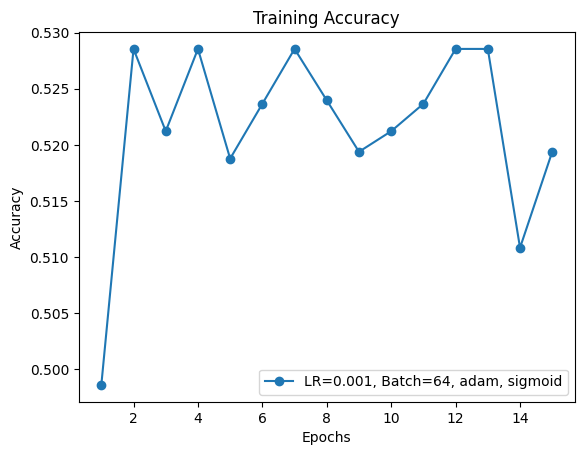

Training with lr=0.001, batch_size=64, optimizer=adam, activation=tanh
Epoch 1, Accuracy: 0.8504
Epoch 2, Accuracy: 0.8986
Epoch 3, Accuracy: 0.9060
Epoch 4, Accuracy: 0.9081
Epoch 5, Accuracy: 0.9087
Epoch 6, Accuracy: 0.9017
Epoch 7, Accuracy: 0.8852
Epoch 8, Accuracy: 0.8873
Epoch 9, Accuracy: 0.8986
Epoch 10, Accuracy: 0.8873
Epoch 11, Accuracy: 0.8873
Epoch 12, Accuracy: 0.8953
Epoch 13, Accuracy: 0.8843
Epoch 14, Accuracy: 0.8742
Epoch 15, Accuracy: 0.8840


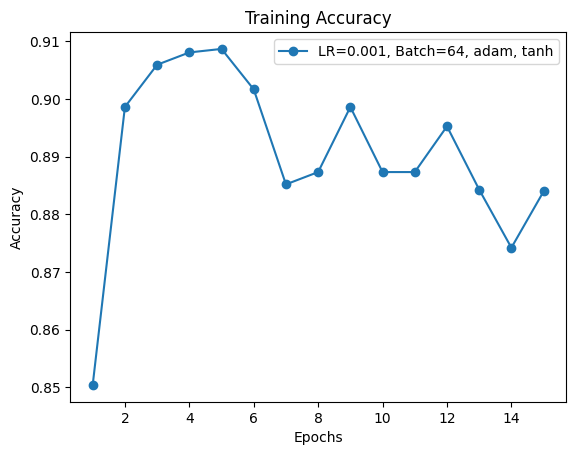

Training with lr=0.001, batch_size=64, optimizer=sgd, activation=relu
Epoch 1, Accuracy: 0.5844
Epoch 2, Accuracy: 0.7805
Epoch 3, Accuracy: 0.8669
Epoch 4, Accuracy: 0.8834
Epoch 5, Accuracy: 0.8916
Epoch 6, Accuracy: 0.8907
Epoch 7, Accuracy: 0.8983
Epoch 8, Accuracy: 0.9014
Epoch 9, Accuracy: 0.9023
Epoch 10, Accuracy: 0.9038
Epoch 11, Accuracy: 0.9124
Epoch 12, Accuracy: 0.9160
Epoch 13, Accuracy: 0.9218
Epoch 14, Accuracy: 0.9264
Epoch 15, Accuracy: 0.9273


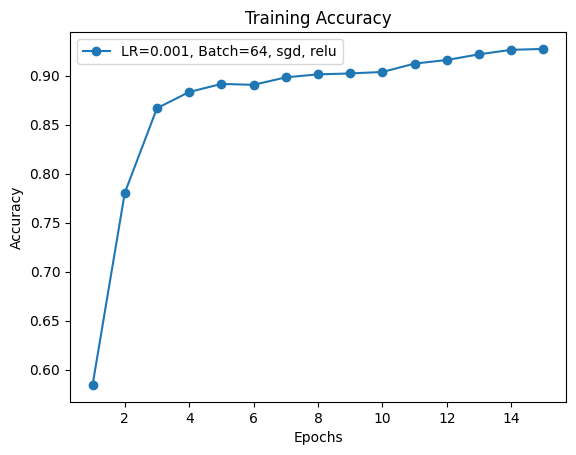

Training with lr=0.001, batch_size=64, optimizer=sgd, activation=sigmoid
Epoch 1, Accuracy: 0.5121
Epoch 2, Accuracy: 0.5121
Epoch 3, Accuracy: 0.5133
Epoch 4, Accuracy: 0.5237
Epoch 5, Accuracy: 0.5011
Epoch 6, Accuracy: 0.5182
Epoch 7, Accuracy: 0.5206
Epoch 8, Accuracy: 0.5115
Epoch 9, Accuracy: 0.5231
Epoch 10, Accuracy: 0.5212
Epoch 11, Accuracy: 0.5240
Epoch 12, Accuracy: 0.5173
Epoch 13, Accuracy: 0.5224
Epoch 14, Accuracy: 0.5188
Epoch 15, Accuracy: 0.5255


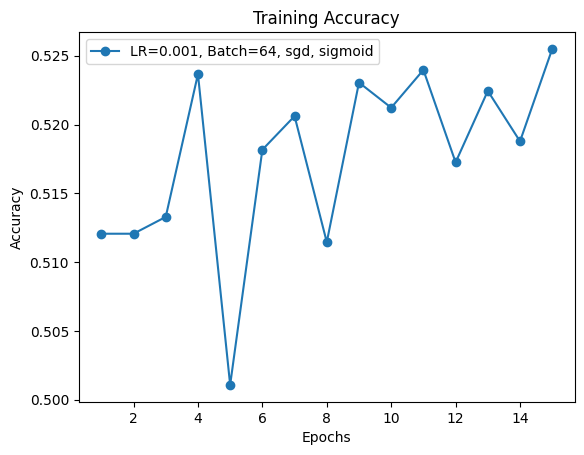

Training with lr=0.001, batch_size=64, optimizer=sgd, activation=tanh
Epoch 1, Accuracy: 0.7600
Epoch 2, Accuracy: 0.8769
Epoch 3, Accuracy: 0.8907
Epoch 4, Accuracy: 0.8950
Epoch 5, Accuracy: 0.9011
Epoch 6, Accuracy: 0.9047
Epoch 7, Accuracy: 0.9105
Epoch 8, Accuracy: 0.9056
Epoch 9, Accuracy: 0.9081
Epoch 10, Accuracy: 0.9133
Epoch 11, Accuracy: 0.9124
Epoch 12, Accuracy: 0.9194
Epoch 13, Accuracy: 0.9227
Epoch 14, Accuracy: 0.9267
Epoch 15, Accuracy: 0.9313


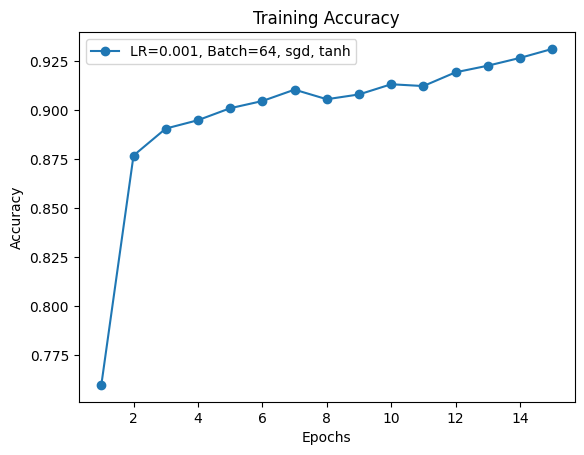

Training with lr=0.001, batch_size=64, optimizer=rmsprop, activation=relu
Epoch 1, Accuracy: 0.5285
Epoch 2, Accuracy: 0.5285
Epoch 3, Accuracy: 0.5285
Epoch 4, Accuracy: 0.5285
Epoch 5, Accuracy: 0.5285
Epoch 6, Accuracy: 0.5285
Epoch 7, Accuracy: 0.5285
Epoch 8, Accuracy: 0.5285
Epoch 9, Accuracy: 0.5285
Epoch 10, Accuracy: 0.5285
Epoch 11, Accuracy: 0.5285
Epoch 12, Accuracy: 0.5285
Epoch 13, Accuracy: 0.5285
Epoch 14, Accuracy: 0.5285
Epoch 15, Accuracy: 0.5285


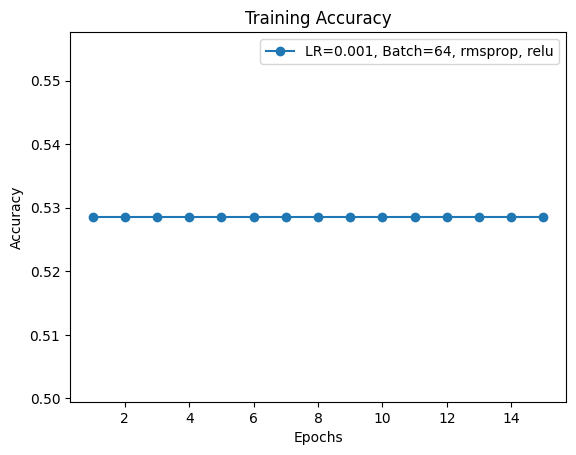

Training with lr=0.001, batch_size=64, optimizer=rmsprop, activation=sigmoid
Epoch 1, Accuracy: 0.5075
Epoch 2, Accuracy: 0.5115
Epoch 3, Accuracy: 0.5255
Epoch 4, Accuracy: 0.5166
Epoch 5, Accuracy: 0.5157
Epoch 6, Accuracy: 0.5206
Epoch 7, Accuracy: 0.5255
Epoch 8, Accuracy: 0.5188
Epoch 9, Accuracy: 0.5139
Epoch 10, Accuracy: 0.5200
Epoch 11, Accuracy: 0.5182
Epoch 12, Accuracy: 0.5169
Epoch 13, Accuracy: 0.5194
Epoch 14, Accuracy: 0.5215
Epoch 15, Accuracy: 0.5197


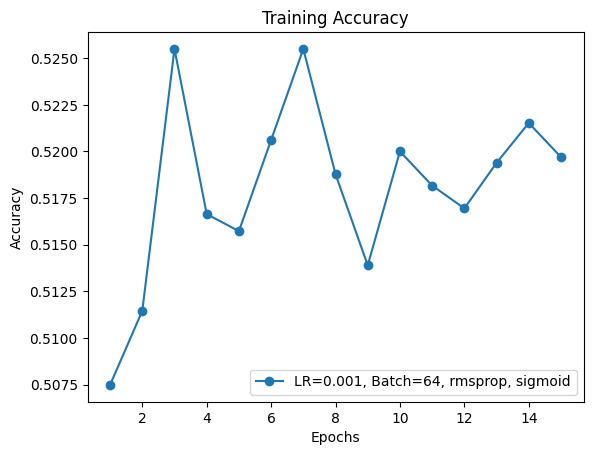

Training with lr=0.001, batch_size=64, optimizer=rmsprop, activation=tanh
Epoch 1, Accuracy: 0.6669
Epoch 2, Accuracy: 0.8540
Epoch 3, Accuracy: 0.8724
Epoch 4, Accuracy: 0.8831
Epoch 5, Accuracy: 0.8882
Epoch 6, Accuracy: 0.8751
Epoch 7, Accuracy: 0.8882
Epoch 8, Accuracy: 0.8873
Epoch 9, Accuracy: 0.8934
Epoch 10, Accuracy: 0.8776
Epoch 11, Accuracy: 0.8840
Epoch 12, Accuracy: 0.8940
Epoch 13, Accuracy: 0.8840
Epoch 14, Accuracy: 0.8907
Epoch 15, Accuracy: 0.8861


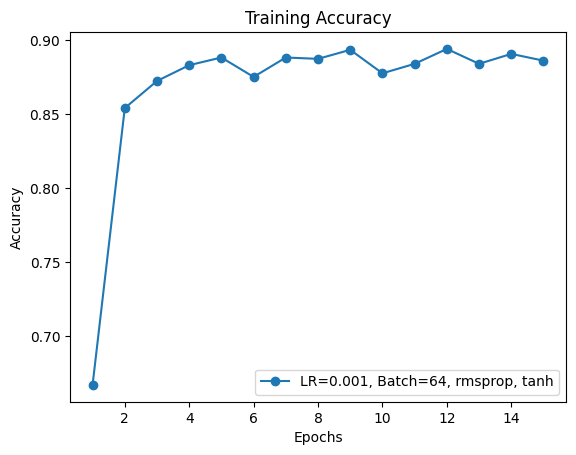

In [19]:
for lr in learning_rates:
    for batch in batch_sizes:
        for opt_name in optimizers:
            for act_name, act_func in activations.items():
                print(f"Training with lr={lr}, batch_size={batch}, optimizer={opt_name}, activation={act_name}")
                model = CNN(act_func)
                criterion = nn.BCELoss()
                
                if opt_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                elif opt_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                else:
                    optimizer = optim.RMSprop(model.parameters(), lr=lr)
                
                acc = train_model(model, criterion, optimizer, epochs=15)
                
                # Plot accuracy
                plt.figure()
                plt.plot(range(1, 16), acc, marker='o', label=f'LR={lr}, Batch={batch}, {opt_name}, {act_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.title('Training Accuracy')
                plt.legend()
                plt.show()